## Random Forest

Random Forest is an ensemble of Decision Trees. With a few exceptions, a `RandomForestClassifier` has all the hyperparameters of a `DecisionTreeClassifier` (to control how trees are grown), plus all the hyperparameters of a `BaggingClassifier` to control the ensemble itself.

The Random Forest algorithm introduces extra randomness when growing trees; instead of searching for the very best feature when splitting a node, it searches for the best feature among a random subset of features. This results in a greater tree diversity, which (once again) trades a higher bias for a lower variance, generally yielding an overall better model. The following `BaggingClassifier` is roughly equivalent to the previous `RandomForestClassifier`. Run the cell below to visualize a single estimator from a random forest model, using the Iris dataset to classify the data into the appropriate species.

In [2]:
from sklearn.datasets import load_iris
iris = load_iris()

# Model (can also use single decision tree)
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=10)

# Train
model.fit(iris.data, iris.target)
# Extract single tree
estimator = model.estimators_[5]

from sklearn.tree import export_graphviz
# Export as dot file
export_graphviz(estimator, out_file='tree.dot', 
                feature_names = iris.feature_names,
                class_names = iris.target_names,
                rounded = True, proportion = False, 
                precision = 2, filled = True)

# Convert to png using system command (requires Graphviz)
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree.png')

FileNotFoundError: [Errno 2] No such file or directory: 'dot'

Notice how each split seperates the data into buckets of similar observations. This is a single tree and a relatively simple classification dataset, but the same method is used in a more complex dataset with greater depth to the trees.

## Coronavirus
Coronavirus disease (COVID-19) is an infectious disease caused by a new virus.
The disease causes respiratory illness (like the flu) with symptoms such as a cough, fever, and in more severe cases, difficulty breathing. You can protect yourself by washing your hands frequently, avoiding touching your face, and avoiding close contact (1 meter or 3 feet) with people who are unwell. An outbreak of COVID-19 started in December 2019 and at the time of the creation of this project was continuing to spread throughout the world. Many governments recommended only essential outings to public places and closed most business that do not serve food or sell essential items. An excellent [spatial dashboard](https://www.arcgis.com/apps/opsdashboard/index.html#/bda7594740fd40299423467b48e9ecf6) built by Johns Hopkins shows the daily confirmed cases by country. 

This case study was designed to drive home the important role that data science plays in real-world situations like this pandemic. This case study uses the Random Forest Classifier and a dataset from the South Korean cases of COVID-19 provided on [Kaggle](https://www.kaggle.com/kimjihoo/coronavirusdataset) to encourage research on this important topic. The goal of the case study is to build a Random Forest Classifier to predict the 'state' of the patient.

First, please load the needed packages and modules into Python. Next, load the data into a pandas dataframe for ease of use.

In [3]:
import os
import pandas as pd
from datetime import datetime,timedelta
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import plotly.graph_objects as go
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor

In [5]:
url ='/Users/bkf/Dropbox/Mac/Desktop/DS Bootcamp Files/RandomForest Covid Case Study_06302020 2/SouthKoreacoronavirusdataset/patientinfo.csv'
df = pd.read_csv(url)
df.head()

,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state
0,1000000001,2.0,male,1964.0,50s,Korea,Seoul,Gangseo-gu,NaN,overseas inflow,1.0,NaN,75.0,2020-01-22,2020-01-23,2020-02-05,NaN,released
1,1000000002,5.0,male,1987.0,30s,Korea,Seoul,Jungnang-gu,NaN,overseas inflow,1.0,NaN,31.0,NaN,2020-01-30,2020-03-02,NaN,released
2,1000000003,6.0,male,1964.0,50s,Korea,Seoul,Jongno-gu,NaN,contact with patient,2.0,2.002000e+09,17.0,NaN,2020-01-30,2020-02-19,NaN,released
3,1000000004,7.0,male,1991.0,20s,Korea,Seoul,Mapo-gu,NaN,overseas inflow,1.0,NaN,9.0,2020-01-26,2020-01-30,2020-02-15,NaN,released
4,1000000005,9.0,female,1992.0,20s,Korea,Seoul,Seongbuk-gu,NaN,contact with patient,2.0,1.000000e+09,2.0,NaN,2020-01-31,2020-02-24,NaN,released


In [6]:
df.shape

(2218, 18)

In [7]:
#Counts of null values 
na_df=pd.DataFrame(df.isnull().sum().sort_values(ascending=False)).reset_index()
na_df.columns = ['VarName', 'NullCount']
na_df[(na_df['NullCount']>0)]

,VarName,NullCount
0,disease,2199
1,deceased_date,2186
2,infection_order,2176
3,symptom_onset_date,2025
4,released_date,1995
5,contact_number,1807
6,infected_by,1749
7,infection_case,1055
8,global_num,904
9,birth_year,454


In [8]:
#counts of response variable values
df.state.value_counts()

state
isolated    1791
released     307
deceased      32
Name: count, dtype: int64

 **<font color='teal'> Create a new column named 'n_age' which is the calculated age based on the birth year column.</font>**

In [9]:
df['n_age'] = 2020-df['birth_year']


In [10]:
df.head(3)

,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state,n_age
0,1000000001,2.0,male,1964.0,50s,Korea,Seoul,Gangseo-gu,NaN,overseas inflow,1.0,NaN,75.0,2020-01-22,2020-01-23,2020-02-05,NaN,released,56.0
1,1000000002,5.0,male,1987.0,30s,Korea,Seoul,Jungnang-gu,NaN,overseas inflow,1.0,NaN,31.0,NaN,2020-01-30,2020-03-02,NaN,released,33.0
2,1000000003,6.0,male,1964.0,50s,Korea,Seoul,Jongno-gu,NaN,contact with patient,2.0,2.002000e+09,17.0,NaN,2020-01-30,2020-02-19,NaN,released,56.0


### Handle Missing Values

 **<font color='teal'> Print the number of missing values by column.</font>**

In [11]:
df.isnull().sum()

patient_id               0
global_num             904
sex                    145
birth_year             454
age                    261
country                  0
province                 0
city                    65
disease               2199
infection_case        1055
infection_order       2176
infected_by           1749
contact_number        1807
symptom_onset_date    2025
confirmed_date         141
released_date         1995
deceased_date         2186
state                   88
n_age                  454
dtype: int64

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2218 entries, 0 to 2217
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   patient_id          2218 non-null   int64  
 1   global_num          1314 non-null   float64
 2   sex                 2073 non-null   object 
 3   birth_year          1764 non-null   float64
 4   age                 1957 non-null   object 
 5   country             2218 non-null   object 
 6   province            2218 non-null   object 
 7   city                2153 non-null   object 
 8   disease             19 non-null     object 
 9   infection_case      1163 non-null   object 
 10  infection_order     42 non-null     float64
 11  infected_by         469 non-null    float64
 12  contact_number      411 non-null    float64
 13  symptom_onset_date  193 non-null    object 
 14  confirmed_date      2077 non-null   object 
 15  released_date       223 non-null    object 
 16  deceas

 **<font color='teal'> Fill the 'disease' missing values with 0 and remap the True values to 1.</font>**

In [13]:
df['disease'] = df['disease'].replace({np.nan: 0, True: 1})


In [14]:
df['disease'].unique()


array([0, 1])

 **<font color='teal'> Fill null values in the following columns with their mean: 'global_number','birth_year','infection_order','infected_by'and 'contact_number'</font>**

In [15]:
# Fill null values with mean - global_number
df['global_num'] = df['global_num'].replace(np.nan, df['global_num'].mean())

In [16]:
# Fill null values with mean - birth_year
df['birth_year'] = df['birth_year'].replace(np.nan, df['birth_year'].mean())

In [17]:
# Fill null values with mean - infection_order
df['infection_order'] = df['infection_order'].replace(np.nan, df['infection_order'].mean())

In [18]:
# Fill null values with mean - infected_by
df['infected_by'] = df['infected_by'].replace(np.nan, df['infected_by'].mean())

In [19]:
# Fill null values with mean - contact_number
df['contact_number'] = df['contact_number'].replace(np.nan, df['contact_number'].mean())

 **<font color='teal'> Fill the rest of the missing values with any method.</font>**

In [20]:
# Fill null values for age related columns - n_age, age

#1 - Fill null value for n_age with calculated values
df['n_age'] = 2020-df['birth_year']

#2 - Fill null values for age by cross-matching the right categorical values

def age_bucket(x): 
  if x>=0 and x<10:    return '0s'
  elif x>=10 and x<20: return '10s'
  elif x>=20 and x<30: return '20s'
  elif x>=30 and x<40: return '30s'
  elif x>=40 and x<50: return '40s'
  elif x>=50 and x<60: return '50s'
  elif x>=60 and x<70: return '60s'
  elif x>=70 and x<80: return '70s'
  elif x>=80 and x<90: return '80s'
  elif x>=90 and x<100: return '90s'
  elif x>=100:         return '100s'

df['age'] = df['n_age'].apply(age_bucket)

In [21]:
#For sex mode used to imput missing vals
df['sex'].value_counts()


sex
female    1171
male       902
Name: count, dtype: int64

In [22]:
df['sex'] = df['sex'].replace(np.nan, 'female')


In [23]:
#For city - mode will be used to impute missing values.

df['city'].value_counts()


city
Gyeongsan-si     535
Cheonan-si        98
Seongnam-si       89
Bonghwa-gun       60
Gumi-si           59
                ... 
Anseong-si         1
pocheon-si         1
Hanam-si           1
Yeongyang-gun      1
Gimje-si           1
Name: count, Length: 134, dtype: int64

In [24]:
df['city'].mode()

0    Gyeongsan-si
Name: city, dtype: object

In [25]:
df['city'] = df['city'].replace(np.nan, df['city'].mode()[0])


<Axes: xlabel='count', ylabel='infection_case'>

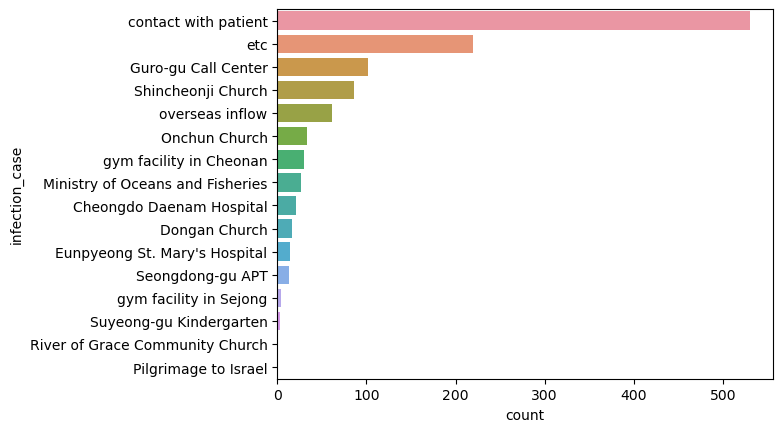

In [26]:
#Infection Case - "etc" will be used to fill the missing values
sns.countplot(data=df, y='infection_case', order=df['infection_case'].value_counts().index)


In [27]:
df['infection_case'].value_counts()


infection_case
contact with patient                530
etc                                 220
Guro-gu Call Center                 102
Shincheonji Church                   86
overseas inflow                      61
Onchun Church                        33
gym facility in Cheonan              30
Ministry of Oceans and Fisheries     27
Cheongdo Daenam Hospital             21
Dongan Church                        17
Eunpyeong St. Mary's Hospital        14
Seongdong-gu APT                     13
gym facility in Sejong                4
Suyeong-gu Kindergarten               3
River of Grace Community Church       1
Pilgrimage to Israel                  1
Name: count, dtype: int64

In [28]:
df['infection_case'] = df['infection_case'].replace(np.nan, 'etc')


In [29]:
#Date/Time Objects - Symptom onset date, confirmed date, released date, deceased date
#Convert all objects back to date/time objects

#1 - converting all objcts into date/time items - 
df['symptom_onset_date'] = pd.to_datetime(df['symptom_onset_date']) 
df['confirmed_date'] = pd.to_datetime(df['confirmed_date']) 
df['released_date'] = pd.to_datetime(df['released_date']) 
df['deceased_date'] = pd.to_datetime(df['deceased_date']) 

In [30]:
#2 - dropping rows where all date/time objects are null
df[['symptom_onset_date', 'confirmed_date', 'released_date', 'deceased_date']].isnull().sum()

symptom_onset_date    2025
confirmed_date         141
released_date         1995
deceased_date         2186
dtype: int64

In [31]:
df = df.dropna(subset=['symptom_onset_date', 'confirmed_date', 'released_date', 'deceased_date'], how='all')


In [32]:
df.shape


(2077, 19)

In [33]:
df.head()

,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state,n_age
0,1000000001,2.0,male,1964.0,50s,Korea,Seoul,Gangseo-gu,0,overseas inflow,1.0,2.600789e+09,75.0,2020-01-22,2020-01-23,2020-02-05,NaT,released,56.0
1,1000000002,5.0,male,1987.0,30s,Korea,Seoul,Jungnang-gu,0,overseas inflow,1.0,2.600789e+09,31.0,NaT,2020-01-30,2020-03-02,NaT,released,33.0
2,1000000003,6.0,male,1964.0,50s,Korea,Seoul,Jongno-gu,0,contact with patient,2.0,2.002000e+09,17.0,NaT,2020-01-30,2020-02-19,NaT,released,56.0
3,1000000004,7.0,male,1991.0,20s,Korea,Seoul,Mapo-gu,0,overseas inflow,1.0,2.600789e+09,9.0,2020-01-26,2020-01-30,2020-02-15,NaT,released,29.0
4,1000000005,9.0,female,1992.0,20s,Korea,Seoul,Seongbuk-gu,0,contact with patient,2.0,1.000000e+09,2.0,NaT,2020-01-31,2020-02-24,NaT,released,28.0


In [34]:
df[['symptom_onset_date', 'confirmed_date', 'released_date', 'deceased_date']].isnull().sum()


symptom_onset_date    1884
confirmed_date           0
released_date         1854
deceased_date         2045
dtype: int64

In [35]:
#3 - filling symptom onset date with average between confirmed date and symptom onset date

avg_sym_to_conf = np.mean(df['confirmed_date']-df['symptom_onset_date'])
print(f'The average symptom to confirmed date is: {avg_sym_to_conf}')

df['symptom_onset_date'] = df['symptom_onset_date'].fillna((df['confirmed_date']-avg_sym_to_conf))

The average symptom to confirmed date is: 4 days 06:57:49.430051813


In [36]:
#4 - filling missing values on released date

avg_conf_to_rel = np.mean(df['released_date']-df['confirmed_date'])
print(f'The average confirmed to released date is: {avg_conf_to_rel}')

The average confirmed to released date is: 13 days 19:54:37.130044843


In [37]:
df.isnull().sum()


patient_id               0
global_num               0
sex                      0
birth_year               0
age                      0
country                  0
province                 0
city                     0
disease                  0
infection_case           0
infection_order          0
infected_by              0
contact_number           0
symptom_onset_date       0
confirmed_date           0
released_date         1854
deceased_date         2045
state                   88
n_age                    0
dtype: int64

In [38]:
# identify how many rows requires null values filled
to_fill = df['state'].loc[(df['state']=='released') & (df['released_date'].isnull())].count()
print(f'There are {to_fill} rows where state = released with empty released dates')

There are 84 rows where state = released with empty released dates


In [39]:
to_be_updated = df['released_date'].loc[(df['state']=='released') & (df['released_date'].isnull())] 
to_be_updated = df['confirmed_date'] + avg_conf_to_rel

In [40]:
#5 - filling mising values on deceased date.
#Only missing value from truly deceased will be filled by using average between confirmed date and deceased date

avg_conf_to_dec = np.mean(df['deceased_date']-df['confirmed_date'])
print(f'The average confirmed to deceased date is: {avg_conf_to_dec}')

# Identify rows where state=deceased and deceased date = null
df.loc[(df['state']=='deceased') & (df['deceased_date'].isnull())]

The average confirmed to deceased date is: 3 days 17:15:00


,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state,n_age
1611,6002000002,4664.816591,male,1980.0,40s,Korea,Gyeongsangbuk-do,Gyeongju-si,0,etc,2.285714,2.600789e+09,24.128954,2020-02-17 17:02:10.569948187,2020-02-22,NaT,NaT,deceased,40.0


In [41]:
# update index 1611
df.loc[1611,'deceased_date'] = df.loc[1611,'confirmed_date']+avg_conf_to_dec
df.iloc[[1611]]

,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state,n_age
1611,6002000002,4664.816591,male,1980.0,40s,Korea,Gyeongsangbuk-do,Gyeongju-si,0,etc,2.285714,2.600789e+09,24.128954,2020-02-17 17:02:10.569948187,2020-02-22,NaT,2020-02-25 17:15:00,deceased,40.0


In [42]:
# identifying for inconsistencies between 'deceased date' and 'status'
df.loc[(df['deceased_date'].notnull()) & (df['state'] !='deceased')]

,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state,n_age
109,1000000110,6781.0,male,1964.0,50s,Korea,Seoul,Gangnam-gu,0,contact with patient,2.285714,2.600789e+09,24.128954,2020-03-02 17:02:10.569948187,2020-03-07,NaT,2020-03-19,released,56.0
187,1000000188,7561.0,female,1994.0,20s,Korea,Seoul,Dongdaemun-gu,0,contact with patient,2.285714,1.000000e+09,24.128954,2020-03-05 17:02:10.569948187,2020-03-10,NaT,2020-03-19,released,26.0


In [43]:
# update 'state' for index 109 & 187 to deceased
df.loc[[109,187],'state'] = 'deceased'
df.iloc[[109, 187]]

,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state,n_age
109,1000000110,6781.0,male,1964.0,50s,Korea,Seoul,Gangnam-gu,0,contact with patient,2.285714,2.600789e+09,24.128954,2020-03-02 17:02:10.569948187,2020-03-07,NaT,2020-03-19,deceased,56.0
187,1000000188,7561.0,female,1994.0,20s,Korea,Seoul,Dongdaemun-gu,0,contact with patient,2.285714,1.000000e+09,24.128954,2020-03-05 17:02:10.569948187,2020-03-10,NaT,2020-03-19,deceased,26.0


In [ ]:
# Check for any remaining null values

In [46]:
df.isnull().sum()


patient_id               0
global_num               0
sex                      0
birth_year               0
age                      0
country                  0
province                 0
city                     0
disease                  0
infection_case           0
infection_order          0
infected_by              0
contact_number           0
symptom_onset_date       0
confirmed_date           0
released_date         1854
deceased_date         2044
state                   88
n_age                    0
dtype: int64

In [48]:
df.head(5)

,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state,n_age
0,1000000001,2.0,male,1964.0,50s,Korea,Seoul,Gangseo-gu,0,overseas inflow,1.0,2.600789e+09,75.0,2020-01-22 00:00:00.000000000,2020-01-23,2020-02-05,NaT,released,56.0
1,1000000002,5.0,male,1987.0,30s,Korea,Seoul,Jungnang-gu,0,overseas inflow,1.0,2.600789e+09,31.0,2020-01-25 17:02:10.569948187,2020-01-30,2020-03-02,NaT,released,33.0
2,1000000003,6.0,male,1964.0,50s,Korea,Seoul,Jongno-gu,0,contact with patient,2.0,2.002000e+09,17.0,2020-01-25 17:02:10.569948187,2020-01-30,2020-02-19,NaT,released,56.0
3,1000000004,7.0,male,1991.0,20s,Korea,Seoul,Mapo-gu,0,overseas inflow,1.0,2.600789e+09,9.0,2020-01-26 00:00:00.000000000,2020-01-30,2020-02-15,NaT,released,29.0
4,1000000005,9.0,female,1992.0,20s,Korea,Seoul,Seongbuk-gu,0,contact with patient,2.0,1.000000e+09,2.0,2020-01-26 17:02:10.569948187,2020-01-31,2020-02-24,NaT,released,28.0


Remove date columns from the data.


In [49]:
df = df.drop(['symptom_onset_date','confirmed_date','released_date','deceased_date'],axis =1)

Review the count of unique values by column.

In [50]:
print(df.nunique())

patient_id         2077
global_num         1304
sex                   2
birth_year           97
age                  11
country               4
province             17
city                130
disease               2
infection_case       16
infection_order       7
infected_by         207
contact_number       73
state                 3
n_age                97
dtype: int64


Review the percent of unique values by column.

In [51]:
print(df.nunique()/df.shape[0])

patient_id         1.000000
global_num         0.627829
sex                0.000963
birth_year         0.046702
age                0.005296
country            0.001926
province           0.008185
city               0.062590
disease            0.000963
infection_case     0.007703
infection_order    0.003370
infected_by        0.099663
contact_number     0.035147
state              0.001444
n_age              0.046702
dtype: float64


Review the range of values per column.

In [52]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
patient_id,2077.0,3.879120e+09,2.200900e+09,1.000000e+09,1.600000e+09,4.100000e+09,6.001000e+09,7.000000e+09
global_num,2077.0,4.664817e+03,2.285663e+03,1.000000e+00,3.947000e+03,4.664817e+03,6.146000e+03,8.717000e+03
birth_year,2077.0,1.975001e+03,1.788104e+01,1.916000e+03,1.964000e+03,1.974989e+03,1.990000e+03,2.020000e+03
disease,2077.0,9.147809e-03,9.522864e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
infection_order,2077.0,2.285852e+00,1.762510e-01,1.000000e+00,2.285714e+00,2.285714e+00,2.285714e+00,6.000000e+00
infected_by,2077.0,2.601463e+09,7.451022e+08,1.000000e+09,2.600789e+09,2.600789e+09,2.600789e+09,6.113000e+09
contact_number,2077.0,2.412895e+01,4.047981e+01,0.000000e+00,2.412895e+01,2.412895e+01,2.412895e+01,1.160000e+03
n_age,2077.0,4.499931e+01,1.788104e+01,0.000000e+00,3.000000e+01,4.501134e+01,5.600000e+01,1.040000e+02


### Check for duplicated rows

In [53]:
duplicateRowsDF = df[df.duplicated()]
duplicateRowsDF

,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,state,n_age


Print the categorical columns and their associated levels.

In [54]:
dfo = df.select_dtypes(include=['object'], exclude=['datetime'])
dfo.shape
#get levels for all variables
vn = pd.DataFrame(dfo.nunique()).reset_index()
vn.columns = ['VarName', 'LevelsCount']
vn.sort_values(by='LevelsCount', ascending =False)
vn

,VarName,LevelsCount
0,sex,2
1,age,11
2,country,4
3,province,17
4,city,130
5,infection_case,16
6,state,3


**<font color='teal'> Plot the correlation heat map for the features.</font>**

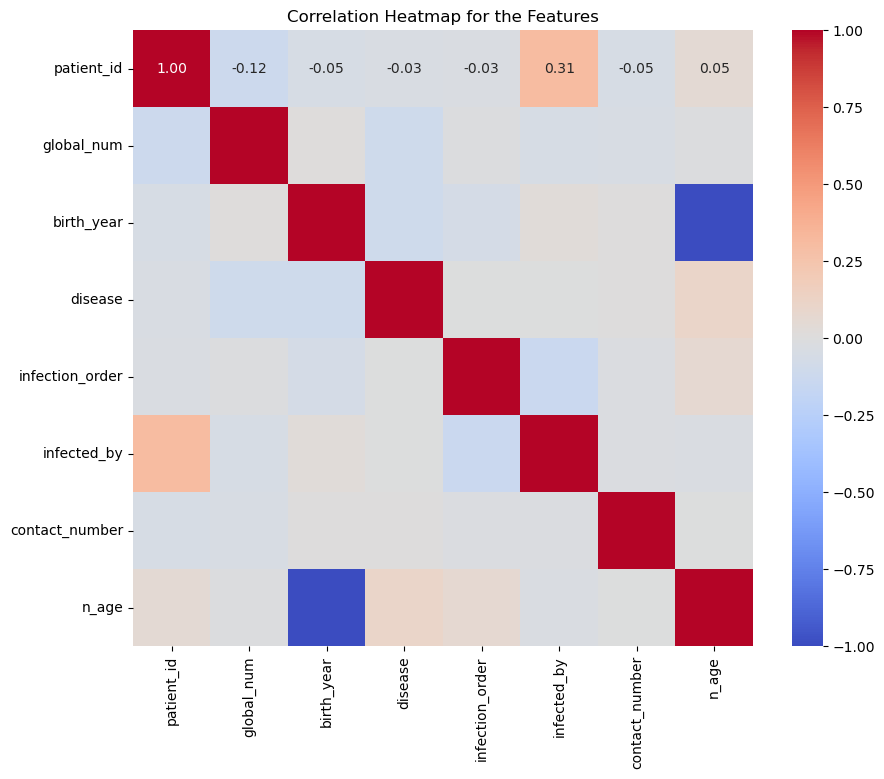

In [56]:
numeric_df = df.select_dtypes(include=[np.number])

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))  # Adjust the figure size as needed
plt.title('Correlation Heatmap for the Features')
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.show()


**<font color='teal'> Plot the boxplots to check for outliers. </font>**

<Axes: >

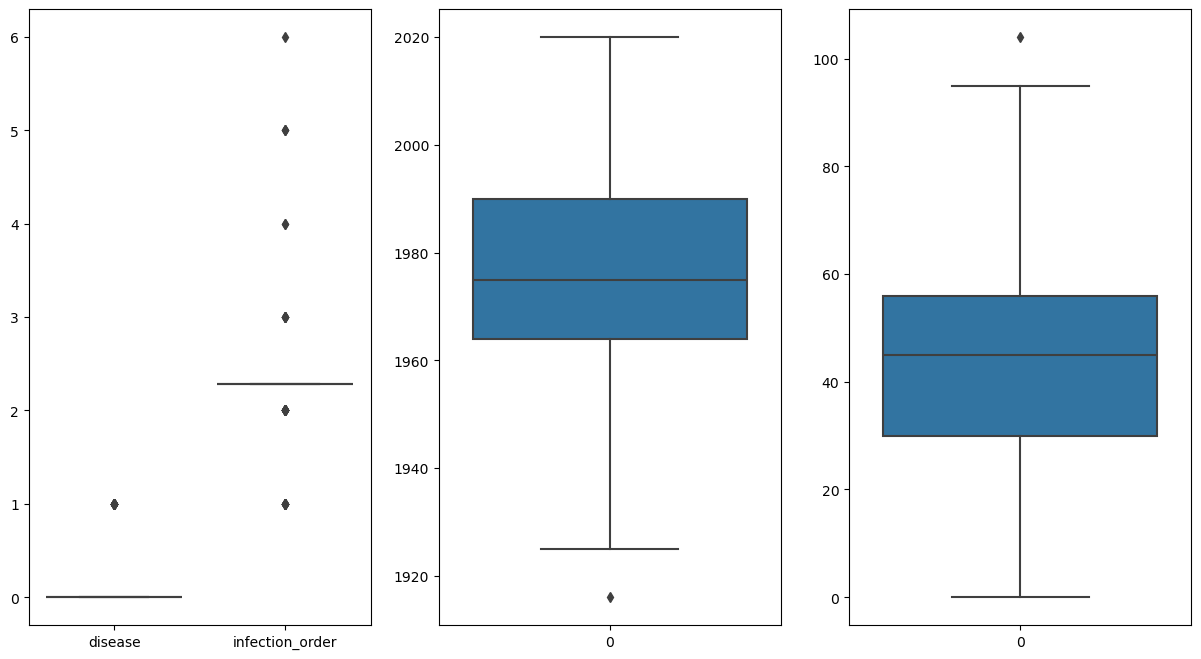

In [57]:
# boxplot (excluding columns functioning as unique identifiers)
df_box = df[['disease', 'infection_order']]
plt.figure(figsize=(15,8))
plt.subplot(1, 3, 1)
sns.boxplot(data=df_box)
plt.subplot(1, 3, 2)
sns.boxplot(data=df['birth_year'])
plt.subplot(1, 3, 3)
sns.boxplot(data=df['n_age'])

**<font color='teal'> Create dummy features for object type features. </font>**

In [58]:
#creating the features 
features = dfo.columns.drop('state')

#creating dummies for 'features'
df_dummies = pd.get_dummies(features)
df_dummies.head(5)

,age,city,country,infection_case,province,sex
0,False,False,False,False,False,True
1,True,False,False,False,False,False
2,False,False,True,False,False,False
3,False,False,False,False,True,False
4,False,True,False,False,False,False


In [59]:
#compiling the final full dataset after dummies created
df_temp = pd.concat([df, df_dummies], axis=1)
df1 = df_temp.drop(features, axis=1)

### Split the data into test and train subsamples

In [60]:
from sklearn.model_selection import train_test_split

# define X and y
features_f = df1.columns.drop('state')

X = df1[features_f]
y = df1['state']

# building the train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

### Scale data to prep for model creation

In [61]:
#scale data
from sklearn import preprocessing
import numpy as np
# build scaler based on training data and apply it to test data to then also scale the test data
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled=scaler.transform(X_train)
X_test_scaled=scaler.transform(X_test)

In [62]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,confusion_matrix,roc_curve,roc_auc_score
from sklearn.metrics import accuracy_score,log_loss
from matplotlib import pyplot

### Fit Random Forest Classifier
The fit model shows an overall accuracy of 80% which is great and indicates our model was effectively able to identify the status of a patients in the South Korea dataset.

In [65]:
#Still NaN values...hmmm???

print(X_train_scaled.isnull().sum())
print(X_test_scaled.isnull().sum())
print(y_train.isnull().sum())
print(y_test.isnull().sum())

AttributeError: 'numpy.ndarray' object has no attribute 'isnull'

In [66]:
X_train_scaled = X_train_scaled.dropna()
y_train = y_train[X_train_scaled.index]  # Ensure the target matches the filtered features

AttributeError: 'numpy.ndarray' object has no attribute 'dropna'

In [63]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=300, random_state = 1,n_jobs=-1)
model_res = clf.fit(X_train_scaled, y_train)
y_pred = model_res.predict(X_test_scaled)
y_pred_prob = model_res.predict_proba(X_test_scaled)
lr_probs = y_pred_prob[:,1]
ac = accuracy_score(y_test, y_pred)

f1 = f1_score(y_test, y_pred, average='weighted')
cm = confusion_matrix(y_test, y_pred)

print('Random Forest: Accuracy=%.3f' % (ac))

print('Random Forest: f1-score=%.3f' % (f1))

ValueError: Input contains NaN

### Create Confusion Matrix Plots
Confusion matrices are great ways to review your model performance for a multi-class classification problem. Being able to identify which class the misclassified observations end up in is a great way to determine if you need to build additional features to improve your overall model. In the example below we plot a regular counts confusion matrix as well as a weighted percent confusion matrix. The percent confusion matrix is particulary helpful when you have unbalanced class sizes.

In [67]:
class_names=['isolated','released','missing','deceased'] # name  of classes

Confusion matrix, without normalization
[[19  0  0]
 [ 0 13  0]
 [ 0  0 13]]
Normalized confusion matrix
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


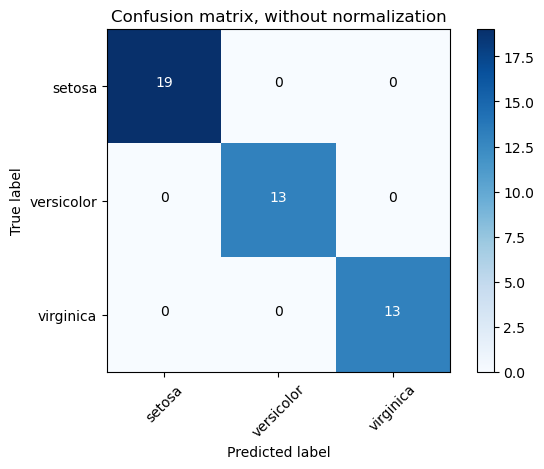

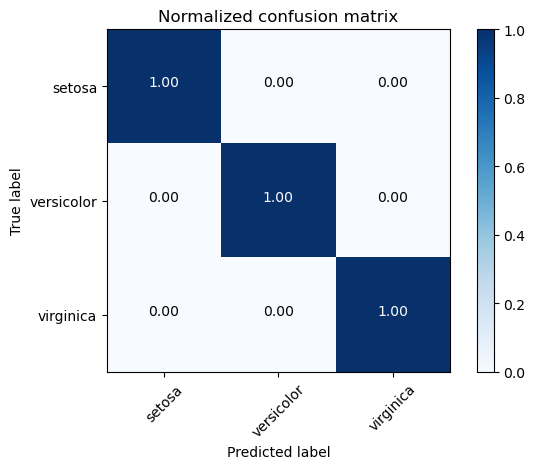

In [69]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# Load dataset
# For example, using the Iris dataset
from sklearn.datasets import load_iris
iris = load_iris()
X = iris.data
y = iris.target
class_names = iris.target_names

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train a model
clf = RandomForestClassifier(n_estimators=300, random_state=1, n_jobs=-1)
model_res = clf.fit(X_train, y_train)

# Make predictions
y_pred = model_res.predict(X_test)

# Define function to plot confusion matrix
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True, title='Normalized confusion matrix')

plt.show()


### Plot feature importances
The random forest algorithm can be used as a regression or classification model. In either case it tends to be a bit of a black box, where understanding what's happening under the hood can be difficult. Plotting the feature importances is one way that you can gain a perspective on which features are driving the model predictions.

AttributeError: 'numpy.ndarray' object has no attribute 'columns'

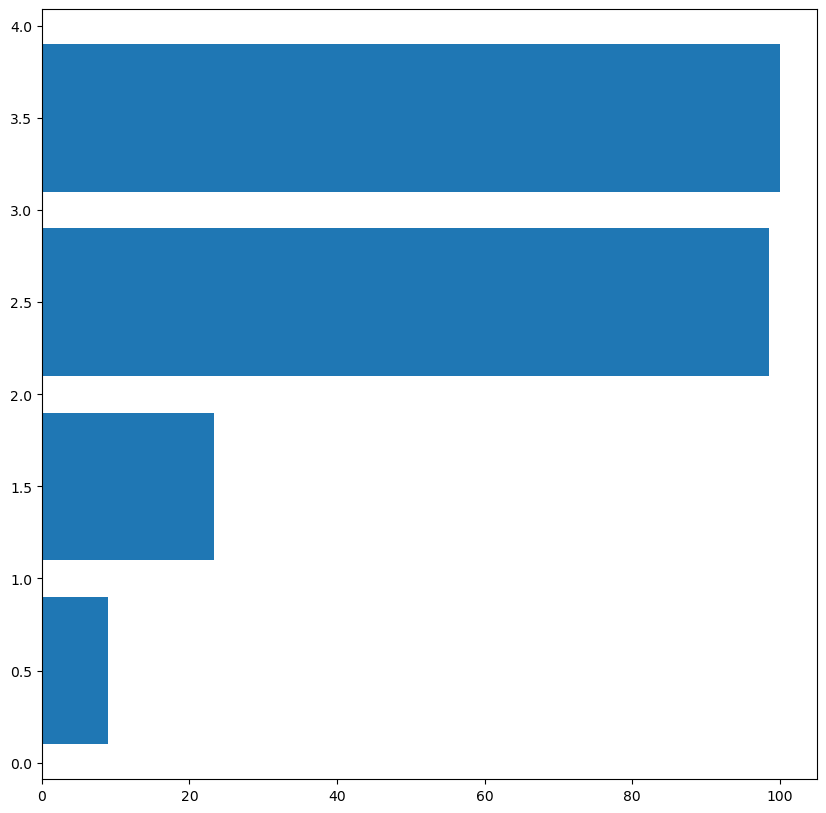

In [72]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming X is your DataFrame and clf is your trained RandomForestClassifier
feature_importance = clf.feature_importances_
# Make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)[-30:]  # Adjusted to take the top 30 features

pos = np.arange(sorted_idx.shape[0]) + .5

plt.figure(figsize=(10, 10))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])  # X.columns works if X is a DataFrame
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()


The popularity of random forest is primarily due to how well it performs in a multitude of data situations. It tends to handle highly correlated features well, where as a linear regression model would not. In this case study we demonstrate the performance ability even with only a few features and almost all of them being highly correlated with each other.
Random Forest is also used as an efficient way to investigate the importance of a set of features with a large data set. Consider random forest to be one of your first choices when building a decision tree, especially for multiclass classifications.